<a href="https://colab.research.google.com/github/HakureiPOI/computer-vision-2025/blob/main/remake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU Available: []


In [2]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

--2025-05-23 08:03:51--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  27.7MB/s    in 60s     

2025-05-23 08:04:52 (31.7 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [3]:
!tar -xf VOCtrainval_11-May-2012.tar

In [4]:
!ls VOCdevkit/VOC2012

Annotations  ImageSets	JPEGImages  SegmentationClass  SegmentationObject


In [89]:
base_path = 'VOCdevkit/VOC2012'

In [90]:
import numpy as np
from PIL import Image

def load_voc_images(path, train=True, max_num=None):
    txt_path = path + f'/ImageSets/Segmentation/{"train.txt" if train else "val.txt"}'
    with open(txt_path, 'r') as f:
        file_names = [x.strip() for x in f.readlines()]
    if max_num is not None:
        file_names = file_names[:min(len(file_names), max_num)]

    features, labels = [], []
    for idx, fname in enumerate(file_names):
        features.append(np.array(Image.open(path + f'/JPEGImages/{fname}.jpg').convert('RGB')))
        labels.append(np.array(Image.open(path + f'/SegmentationClass/{fname}.png').convert('RGB')))

    return features, labels

In [91]:
sample_features, sample_labels = load_voc_images(base_path, train=True, max_num=10)

In [92]:
def crop_images(features, labels, crop_size, tolerance=10, bg_threshold=0.6):
    cropped_features, cropped_labels = [], []

    for feature, label in zip(features, labels):
        h, w, _ = feature.shape
        if h < crop_size or w < crop_size:
            continue

        for _ in range(tolerance):
            start_h = np.random.randint(0, h - crop_size)
            start_w = np.random.randint(0, w - crop_size)

            crop_feat = feature[start_h:start_h + crop_size, start_w:start_w + crop_size, :]
            crop_label = label[start_h:start_h + crop_size, start_w:start_w + crop_size, :]

            bg_mask = np.all(crop_label == 0, axis=-1)
            bg_ratio = np.mean(bg_mask)

            if bg_ratio <= bg_threshold:
                cropped_features.append(crop_feat)
                cropped_labels.append(crop_label)
                break

    return np.array(cropped_features), np.array(cropped_labels)

In [106]:
img_size = 128

In [93]:
sample_features_cropped, sample_labels_cropped = crop_images(sample_features, sample_labels, crop_size=img_size)

In [94]:
len(sample_labels_cropped)

6

In [95]:
from matplotlib import pyplot as plt

def show_images(features, labels, num_images=1):
    for i in range(num_images):
        plt.subplot(1, 2, 1)
        plt.imshow(features[i])
        plt.subplot(1, 2, 2)
        plt.imshow(labels[i])
        plt.show()

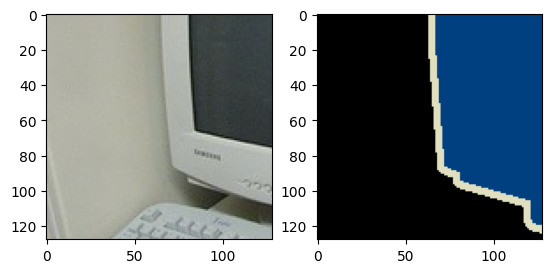

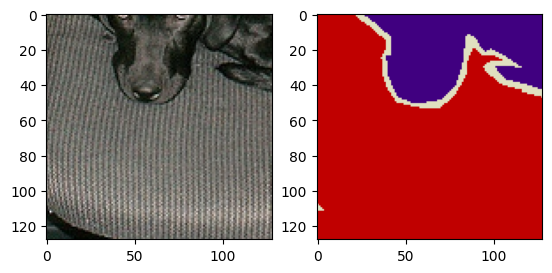

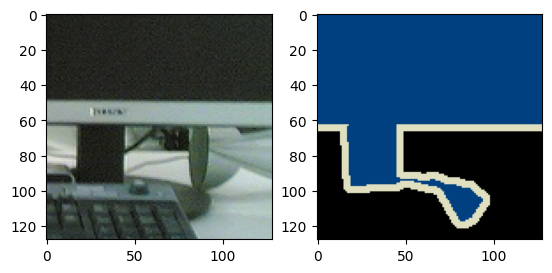

In [96]:
show_images(sample_features_cropped, sample_labels_cropped, 3)

In [97]:
VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
    [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
    [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
    [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
    [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
    [0, 64, 128]
]

VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
    'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor'
]

In [98]:
def build_colormap2label(colormap):
    cm2lbl = np.zeros(256 ** 3, dtype=np.uint8)
    for idx, color in enumerate(colormap):
        r, g, b = color
        cm2lbl[(r * 256 + g) * 256 + b] = idx
    return cm2lbl

cm2lbl = build_colormap2label(VOC_COLORMAP)

def voc_label_indices(label_img):
    data = label_img.astype('int32')
    idx = (data[:, :, 0] * 256 + data[:, :, 1]) * 256 + data[:, :, 2]
    return cm2lbl[idx]

def convert_voc_rgb_labels(y_list):
    return np.array([voc_label_indices(y) for y in y_list])

In [101]:
def load_voc_dataset(train=True, max_num=None, crop_size=128):
    features, labels = load_voc_images(base_path, train=train, max_num=max_num)
    features_cropped, labels_cropped = crop_images(features, labels, crop_size=crop_size)
    features_cropped = features_cropped.astype('float32') / 255.0
    labels_cropped = convert_voc_rgb_labels(labels_cropped)

    return features_cropped, labels_cropped

In [102]:
X_train, y_train = load_voc_dataset(train=True, max_num=200)
X_test, y_test = load_voc_dataset(train=False, max_num=100)

In [104]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((170, 128, 128, 3), (170, 128, 128), (87, 128, 128, 3), (87, 128, 128))

In [110]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1000) \
                             .batch(batch_size) \
                             .prefetch(AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(AUTOTUNE)

In [114]:
from tensorflow.keras import layers, Model

class BasicBlock(tf.keras.Model):
    def __init__(self, in_channels, out_channels, stride=1, downsample=False):
        super(BasicBlock, self).__init__()

        self.conv1 = layers.Conv2D(out_channels, kernel_size=3, strides=stride, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.ReLU()

        self.conv2 = layers.Conv2D(out_channels, kernel_size=3, strides=1, padding='same', use_bias=False)
        self.bn2 = layers.BatchNormalization()

        if downsample:
            self.downsample = tf.keras.Sequential([
                layers.Conv2D(out_channels, kernel_size=1, strides=stride, use_bias=False),
                layers.BatchNormalization()
            ])
        else:
            self.downsample = tf.keras.layers.Lambda(lambda x: x)

    def call(self, x, training=False):
        identity = self.downsample(x, training=training)

        out = self.conv1(x)
        out = self.bn1(out, training=training)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out, training=training)

        out += identity
        return self.relu(out)

class CustomResNet(tf.keras.Model):
    def __init__(self):
        super(CustomResNet, self).__init__()
        self.conv1 = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.maxpool = layers.MaxPool2D(pool_size=3, strides=2, padding='same')

        self.layer1 = tf.keras.Sequential([
            BasicBlock(64, 64),
            BasicBlock(64, 64)
        ])
        self.layer2 = tf.keras.Sequential([
            BasicBlock(64, 128, stride=2, downsample=True),
            BasicBlock(128, 128)
        ])
        self.layer3 = tf.keras.Sequential([
            BasicBlock(128, 256, stride=2, downsample=True),
            BasicBlock(256, 256)
        ])
        self.layer4 = tf.keras.Sequential([
            BasicBlock(256, 512, stride=2, downsample=True),
            BasicBlock(512, 512)
        ])

        self.conv_last = layers.Conv2D(21, kernel_size=1)
        self.upsample = layers.Conv2DTranspose(21, kernel_size=64, strides=32, padding='same')

    def call(self, x, training=False):
        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)

        x = self.conv_last(x)
        x = self.upsample(x)
        return x


In [115]:
model = CustomResNet()
model.summary()

Model: "custom_res_net_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_63 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_27 (ReLU)                 │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_21 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_23 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_25 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_27 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [116]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [117]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=20
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.1320 - loss: 2.9686 - val_accuracy: 0.3199 - val_loss: 2.9391
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.3984 - loss: 2.3776 - val_accuracy: 0.1433 - val_loss: 18.9469
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.4279 - loss: 2.2069 - val_accuracy: 0.0451 - val_loss: 284.3052
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.4146 - loss: 2.1535 - val_accuracy: 0.0462 - val_loss: 273.7935
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.4418 - loss: 2.0919 - val_accuracy: 0.0247 - val_loss: 229.2888
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.4446 - loss: 2.0263 - val_accuracy: 0.0426 - val_loss: 116.3718
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.4368 - loss: 2.0546 - val_accuracy: 0.0406 - val_loss: 67.7561
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.4656 - loss: 1.8994 - val_accuracy: 0.0749 - val_loss: 41.38

In [118]:
def label_to_rgb(label_map):
    colormap = np.array(VOC_COLORMAP, dtype=np.uint8)
    return colormap[label_map]

def visualize_prediction(model, dataset, num_images=4):
    for images, masks in dataset.take(1):
        preds = model(images, training=False)
        preds = tf.argmax(preds, axis=-1).numpy()  # (B, H, W)
        masks = masks.numpy()  # (B, H, W)

        images = images.numpy()

        for i in range(num_images):
            image = (images[i] * 255).astype(np.uint8)
            pred_mask = label_to_rgb(preds[i])
            true_mask = label_to_rgb(masks[i])

            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow(image)
            axes[0].set_title("Input Image")
            axes[1].imshow(true_mask)
            axes[1].set_title("Ground Truth")
            axes[2].imshow(pred_mask)
            axes[2].set_title("Prediction")
            for ax in axes:
                ax.axis('off')
            plt.tight_layout()
            plt.show()

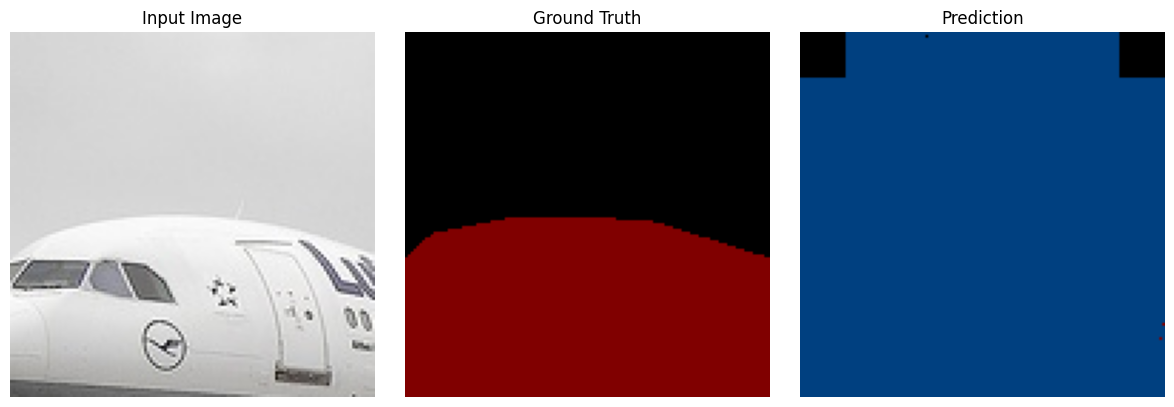

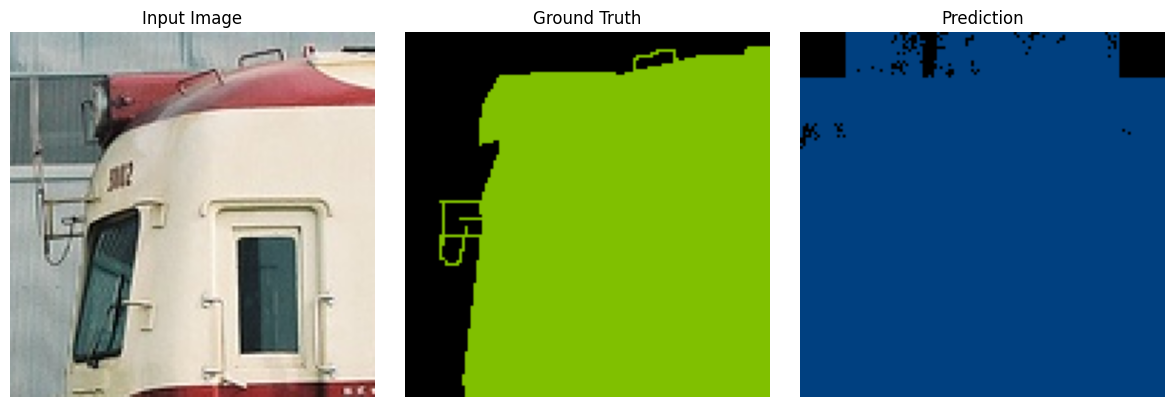

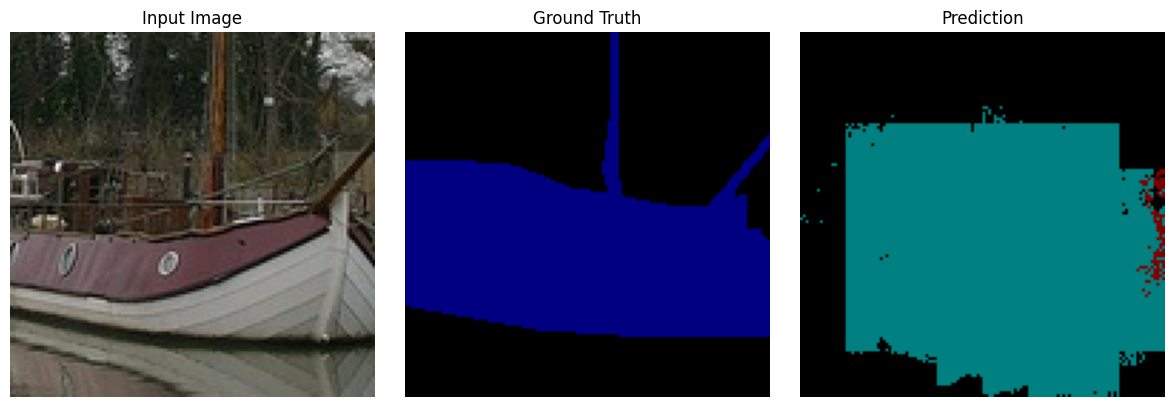

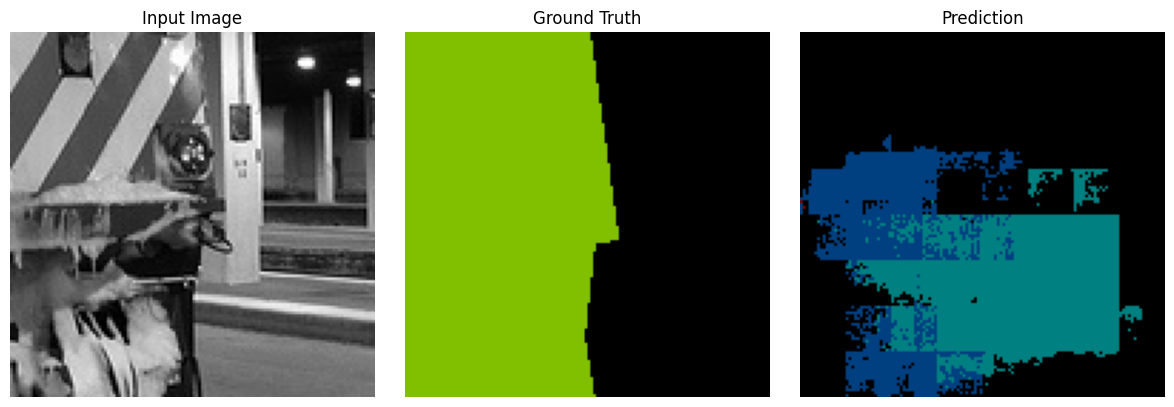

In [119]:
visualize_prediction(model, test_dataset, num_images=4)